# TaatikNet: Converting between Hebrew text and Latin transliteration
## A simple demonstration of character-level seq2seq training

Many NLP tasks require converting an input text sequence into some other text -- **seq2seq tasks**:
* Machine translation (e.g. English to German)
* Text summarization and paraphrasing (e.g. long English to short English)
* Spelling correction (misspelled text to valid text)

Given a dataset of paired text data, how can we easily train a deep learning model to convert from one domain to another?

Let's see how to do this using an interesting and challenging example -- converting between **Hebrew text** (with or without vowel marks) and **Latin transliteration**. We call our resulting model **TaatikNet** (תעתיק *taatik* means "transliteration" in Hebrew).

Let's get started!

# Requirements

Make sure the requirements from `requirements.txt` are installed (`pip install -r requirements.txt`).

If you run this notebook in Google Colab, uncomment the following line. You will also need to upload the dataset csv file manually.

In [1]:
# pip install transformers accelerate

Let's get our imports out of the way now...

In [2]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from transformers import pipeline
from tqdm.auto import trange, tqdm
import torch

2023-06-25 07:00:08.645229: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-25 07:00:08.668081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 07:00:09.025064: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data wrangling

We'll use the provided dataset of Hebrew words and Latin transliterations, derived from the [Hebrew Wiktionary](https://he.wiktionary.org).

In [3]:
df = pd.read_csv('data/he_transliterations.csv')

We see it contains nearly 15K words. The transliterations usually have an accented vowel to mark stress:

In [4]:
print(len(df.shape), 'rows')
df.head()

2 rows


,word,nikkud,transliteration
0,אאוגניקה,אֵאוּגֶנִיקָה,eugénika
1,אאוזינופיל,אֵאוֹזִינוֹפִיל,e'ozinofil
2,אאוטינג,אָאוּטִינְג,autíng
3,אב,אָב,av
4,אב,אַב,av


To make this useable for training our model, we must convert it into a PyTorch Dataset object:

In [5]:
def randomly_remove_accent(text, prob):
    if np.random.random() < prob:
        return text.replace(f'\u0341', '')
    return text

class DS(Dataset):
    def __init__(self):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        out = {}
        if np.random.random() < 0.5:
            out['input'] = row.word if np.random.random() < 0.2 else row.nikkud
            out['target'] = row.transliteration
        else:
            out['input'] = randomly_remove_accent(row.transliteration, 0.5)
            out['target'] = row.nikkud
        return out

ds = DS()

We've added code to randomly augment our data by having Hebrew text as either input or output, and by randomly dropping vowels or accent signs in the input text, as seen below:

In [6]:
for _ in range(10):
    print(ds[0])

{'input': 'אֵאוּגֶנִיקָה', 'target': 'eugénika'}
{'input': 'eugenika', 'target': 'אֵאוּגֶנִיקָה'}
{'input': 'eugénika', 'target': 'אֵאוּגֶנִיקָה'}
{'input': 'eugénika', 'target': 'אֵאוּגֶנִיקָה'}
{'input': 'eugenika', 'target': 'אֵאוּגֶנִיקָה'}
{'input': 'אאוגניקה', 'target': 'eugénika'}
{'input': 'eugénika', 'target': 'אֵאוּגֶנִיקָה'}
{'input': 'אֵאוּגֶנִיקָה', 'target': 'eugénika'}
{'input': 'אֵאוּגֶנִיקָה', 'target': 'eugénika'}
{'input': 'אֵאוּגֶנִיקָה', 'target': 'eugénika'}




This would be slightly simpler if we only wanted to convert from one row of our DataFrame to the other (e.g. training a model to transliteration Hebrew text with vowels). Then we could replace all the code in `__getitem__` with something like `return row.to_dict()`. However, with this augmentation our model learns something more interesting -- to convert in either direction, and to handle input that may or may not contain vowels or accents.

# Base model: ByT5

We first load our base model ByT5-small ([paper](https://arxiv.org/abs/2105.13626), [HF model page](https://huggingface.co/google/byt5-small)), a byte-level (tokenizer-free) encoder-decoder transformer model:

In [7]:
pipe = pipeline("text2text-generation", model='google/byt5-small', device_map='auto')

For other seq2seq tasks you could simply replace BytT5 with any other encoder-decoder model. In our case, since our tasks uses non-Latin characters and involves reasoning on the character level, this model is more appropriate.


Note: The related UNIKUD project ([post](https://towardsdatascience.com/unikud-adding-vowels-to-hebrew-text-with-deep-learning-powered-by-dagshub-56d238e22d3f), [repo](https://github.com/morrisalp/unikud)) used the encoder-only model CANINE as a base; here we use an encoder-decoder model since we must output text of arbitrary length.

# Training

We use the following settings:

In [8]:
epochs = 10
batch_size = 32
lr = 1e-3

We did not extensively tune these hyperparameters -- try playing with them and see if you can improve our results!

We set up data loading with simple collation (adding padding to inputs and converting them into tensors per minibatch):

In [9]:
def collate(B):
    inputs = [x['input'] for x in B]
    targets = [x['target'] for x in B]
    inp = pipe.tokenizer(
        inputs,
        text_target=targets,
        max_length=100,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )
    return inp

dl = DataLoader(
    ds,
    collate_fn=collate,
    shuffle=True,
    batch_size=batch_size
)

Note that we do not bother here with validation or testing splits since this is just a simple demo.

Our model is not yet tuned for our task so as expected, it outputs gibberish:

In [10]:
def evaluate(i, items=['algoritm', 'kokoro', 'יִשְׂרָאֵל', 'דוריטוס', 'ajiliti', "פאנץ'", 'etherium']):
    pipe.model.eval()
    for x in items:
        print(f'Epoch {i}: {x} =>',
            pipe(x, max_length=100)[0]['generated_text'])

evaluate(0)

Epoch 0: algoritm => 22222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222
Epoch 0: kokoro => okoroo-oroa-oroa-oroa-oroa-oroa-oroa-oroa-oroa-oroa-oroa-oroa-oroa-oroa-oroa-oroa-oroa-oroa-oroa-o
Epoch 0: יִשְׂרָאֵל => אלאלאלאלאלאלאלאלאלאלאלאלאלאלאלאלאלאלאלאלאלאלאלאלא
Epoch 0: דוריטוס => וסטריטוס
סוריטוס
סוריטוס
סוריטוס
סוריטוס
סוריטוס
סור
Epoch 0: ajiliti => ajabiliti siti siti siti siti siti siti siti siti siti siti siti siti siti siti siti siti siti sit
Epoch 0: פאנץ' => ץ'ץ'אנץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'ץ'
Epoch 0: etherium => thethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethetheth


Now let's train our model and see how its output changes per epoch. This should take about half an hour to complete on GPU:

In [11]:
optimizer = torch.optim.AdamW(pipe.model.parameters(), lr=lr)
losses = []

for i in trange(epochs):
    pipe.model.train()
    for B in tqdm(dl):
        optimizer.zero_grad()
        loss = pipe.model(**B).loss
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    evaluate(i + 1)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 1: algoritm => מְשִׁית
Epoch 1: kokoro => מְשִׁית
Epoch 1: יִשְׂרָאֵל => mará
Epoch 1: דוריטוס => mará


/home/morrisalper/miniconda3/envs/notebooks/lib/python3.9/site-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Epoch 1: ajiliti => מְשִׁית
Epoch 1: פאנץ' => mará
Epoch 1: etherium => מְשִׁית


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 2: algoritm => אַלְגּוֹרִיטִיטִיטִיטִיטִיטִיטִיטִים
Epoch 2: kokoro => כּוֹקוֹרְבּוֹרוֹר
Epoch 2: יִשְׂרָאֵל => yishishál
Epoch 2: דוריטוס => dirít
Epoch 2: ajiliti => אַדִּיטִי
Epoch 2: פאנץ' => pitsút
Epoch 2: etherium => אֶתֶרִיוּם


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 3: algoritm => אַלְגּוֹרִיתְם
Epoch 3: kokoro => כּוֹקוֹרוֹ
Epoch 3: יִשְׂרָאֵל => yisra'él
Epoch 3: דוריטוס => doritós
Epoch 3: ajiliti => עֲגִילִיתִי
Epoch 3: פאנץ' => pa'ants
Epoch 3: etherium => אֶתְהֶרִיוּם


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 4: algoritm => אַלְגּוֹרִיטְם
Epoch 4: kokoro => קוֹקוֹרוֹ
Epoch 4: יִשְׂרָאֵל => yisraél
Epoch 4: דוריטוס => doritós
Epoch 4: ajiliti => אֲגִילִיטִיתִי
Epoch 4: פאנץ' => pa'ants
Epoch 4: etherium => אֶתְהֵרִיאוּם


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 5: algoritm => אַלְגּוֹרִיתְם
Epoch 5: kokoro => קוֹקוֹרוֹ
Epoch 5: יִשְׂרָאֵל => yisraél
Epoch 5: דוריטוס => doritós
Epoch 5: ajiliti => אֲגִילִיטִי
Epoch 5: פאנץ' => pánts
Epoch 5: etherium => אֶתְהֵרִים


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 6: algoritm => אַלְגּוֹרִיטְם
Epoch 6: kokoro => קוֹקוֹרוֹ
Epoch 6: יִשְׂרָאֵל => yisraél
Epoch 6: דוריטוס => doritós
Epoch 6: ajiliti => אֲגִ'ילִיטִי
Epoch 6: פאנץ' => pa'aná
Epoch 6: etherium => אֶתֶרְיוּם


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 7: algoritm => אַלְגּוֹרִיטְם
Epoch 7: kokoro => קוֹקוֹרוֹ
Epoch 7: יִשְׂרָאֵל => yisraél
Epoch 7: דוריטוס => dorítos
Epoch 7: ajiliti => אָגִ'ילִיטִי
Epoch 7: פאנץ' => pa'anách
Epoch 7: etherium => אֶתְהֵרְיוּם


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 8: algoritm => אַלְגּוֹרִיתִיתִיתִיתִיתִיתִיתִיתִיתִיתִיתִיתִיתִ
Epoch 8: kokoro => קוֹקוֹרוֹ
Epoch 8: יִשְׂרָאֵל => yisrál
Epoch 8: דוריטוס => dorítos
Epoch 8: ajiliti => אֲגִ'ילִיטִי
Epoch 8: פאנץ' => pántsh
Epoch 8: etherium => אֶתֶרְיוּם


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 9: algoritm => אַלְגּוֹרִיטְם
Epoch 9: kokoro => קוֹקוֹרוֹ
Epoch 9: יִשְׂרָאֵל => yisraél
Epoch 9: דוריטוס => dorítos
Epoch 9: ajiliti => אָגִ'ילִיטִי
Epoch 9: פאנץ' => pa'anátsh
Epoch 9: etherium => אֶתְהֶרְיוּם


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 10: algoritm => אַלְגּוֹרִיטְם
Epoch 10: kokoro => קוֹקוֹרוֹ
Epoch 10: יִשְׂרָאֵל => yisraél
Epoch 10: דוריטוס => dorítos
Epoch 10: ajiliti => אָגִ'ילִיטִי
Epoch 10: פאנץ' => pénetsh
Epoch 10: etherium => אֶתֶרְיוּם


# Final steps

Check out the model's (train) loss curve, and compare it to the outputs. We suspect the model first masters the prior distributions on Hebrew words and transliterations, and only later manages to understand the connection between the two:

<Axes: >

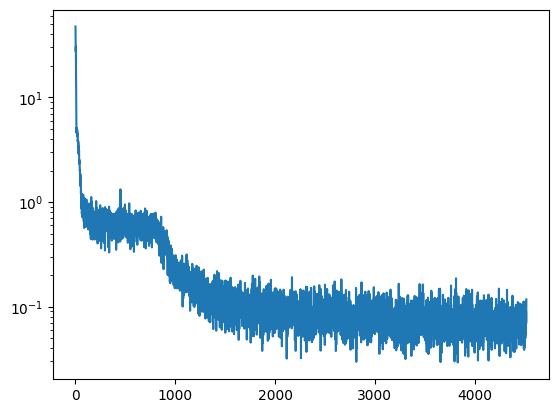

In [12]:
pd.Series(losses).plot(logy=True)

Finally, let's save our work 😊

In [13]:
pipe.save_pretrained('taatiknet')

See the instructions in the README for inference. You may also play with a deployed version of TaatikNet at the [interactive demo](https://huggingface.co/spaces/malper/taatiknet) hosted by Hugging Face Spaces.

If you went through this demo then congrats! You've trained a seq2seq model to solve a complex problem with a minimal amount of code. This demo could be easily adapted to training on datasets for most text-to-text generation problems by replacing ByT5 with any appropriate [encoder-decoder model](https://huggingface.co/docs/transformers/model_doc/encoder-decoder).

Feel free to reach out to [Morris Alper](https://morrisalp.github.io/) with any questions, comments or suggestions on this demo.